# Testing ML-based Outlier Detectors

There are various ways to deal with outliers in general. However, detection and removal of these in an automatic manner is a challenge. Especially since normal statistical techniques will not work due to the behaviour and variance of resonance characteristics of nuclear reaction data. In this small notebook, an example using four different outlier detectors is shown on the resonance region of the U-235(n,g) reaction. 

In [ ]:
# # Prototype
# import sys
# sys.path.append("..")

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

import nucml.datasets as nuc_data
import nucml.exfor.data_utilities as exfor_utils

In [2]:
sns.set(font_scale=2.5)
sns.set_style("white")

# Setting up the path where our figures will be stored
figure_dir = "Figures/"

Let us load the data using `NucML`:

In [3]:
df = nuc_data.load_exfor(low_en=True, max_en=2E7, filters=True)
df.MT = df.MT.astype(int)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: False
INFO:root: BASIC: -1
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons/EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4184115, 104)
INFO:root:Finished. Resulting dataset has shape (4184115, 104)


With the EXFOR data loaded, let us extract only the U-235(N,G) datapoints as an example and transform it by applying the logarithm.

In [4]:
u235_ng = exfor_utils.load_samples(df, 92, 235, 102)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (10872, 104)


In [5]:
u235_ng = np.log10(u235_ng[["Energy", "Data"]])

One shared drawback between statistical methods and these types of algorithms is the inability to handle the resonance behavior correctly. To make it easier for the model let us manually extract the resonance region.

In [7]:
u235_ng = u235_ng[u235_ng.Energy < 4]
u235_ng = u235_ng[u235_ng.Energy > 0.5]

However, the main drawback comes from the fact that the outlier fraction needs to be specified. Since here we are only doing an example, we can set it manually but time is needed to think about how to approach this problem more efficiently and persistently.

In [115]:
outliers_fraction = 0.003

## Isolation Forest

In [114]:
from sklearn.ensemble import IsolationForest

In [117]:
iso_forest_fraction = IsolationForest(n_estimators = 200, contamination=outliers_fraction)

In [118]:
iso_forest_fraction.fit(u235_ng[["Data"]])

IsolationForest(contamination=0.003, n_estimators=200)

In [119]:
u235_ng["iso_fraction"] = iso_forest_fraction.predict(u235_ng[["Data"]])

In [120]:
iso_class1 = u235_ng[u235_ng.iso_fraction == 1]
iso_class2 = u235_ng[u235_ng.iso_fraction == -1]

## One Class SVM

In [122]:
from sklearn import svm

In [123]:
svm_outlier_detector = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)

In [124]:
svm_outlier_detector.fit(u235_ng[["Data"]])

OneClassSVM(gamma=0.1, nu=0.003)

In [125]:
u235_ng["svm"] = svm_outlier_detector.predict(u235_ng[["Data"]])

In [126]:
svm_class1 = u235_ng[u235_ng.svm == 1]
svm_class2 = u235_ng[u235_ng.svm == -1]

## Local Outlier Factor

In [128]:
from sklearn.neighbors import LocalOutlierFactor

In [129]:
local_outlier = LocalOutlierFactor(n_neighbors=500, contamination=0.005)

u235_ng["local"] = local_outlier.fit_predict(u235_ng[["Data"]])

local_class1 = u235_ng[u235_ng.local == 1]
local_class2 = u235_ng[u235_ng.local == -1]

## Elliptic Envelope

In [131]:
from sklearn.covariance import EllipticEnvelope

In [136]:
robust = EllipticEnvelope(contamination=outliers_fraction)

In [137]:
robust.fit(u235_ng[["Data"]])

EllipticEnvelope(contamination=0.003)

In [138]:
u235_ng["robust"] = robust.predict(u235_ng[["Data"]])

In [139]:
robust_class1 = u235_ng[u235_ng.svm == 1]
robust_class2 = u235_ng[u235_ng.svm == -1]

## Plotting Outliers

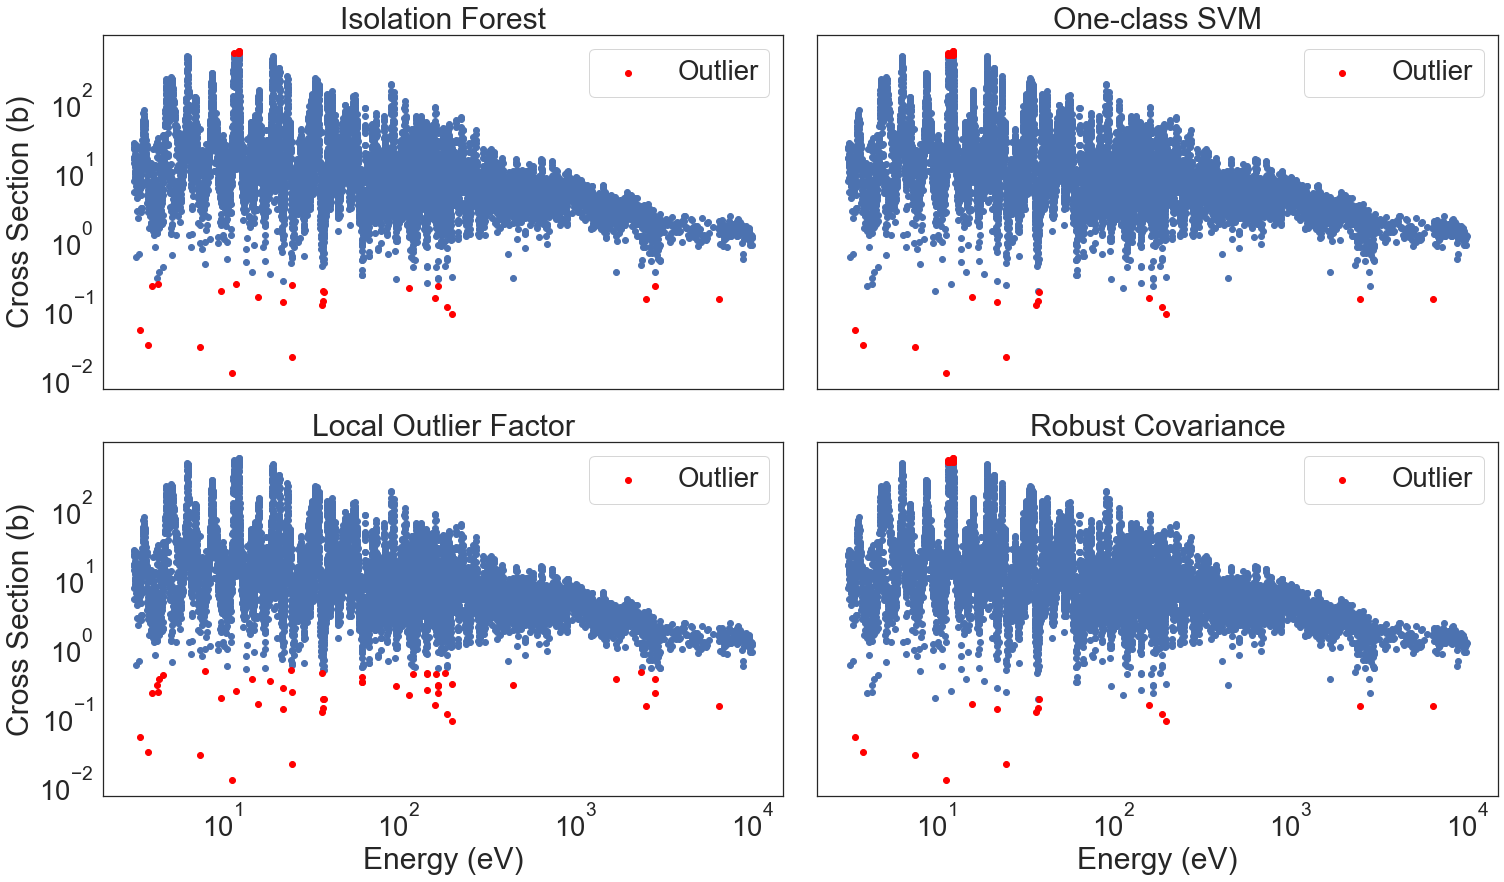

In [175]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25,14), gridspec_kw={'hspace': 0.15, 'wspace':0.05})

ax1.scatter(10**(iso_class1.Energy), 10**(iso_class1.Data))
ax1.scatter(10**(iso_class2.Energy), 10**(iso_class2.Data), color="red", label="Outlier")

ax2.scatter(10**(svm_class1.Energy), 10**(svm_class1.Data))
ax2.scatter(10**(svm_class2.Energy), 10**(svm_class2.Data), color="red", label="Outlier")

ax3.scatter(10**(local_class1.Energy), 10**(local_class1.Data))
ax3.scatter(10**(local_class2.Energy), 10**(local_class2.Data), color="red", label="Outlier")

ax4.scatter(10**(robust_class1.Energy), 10**(robust_class1.Data))
ax4.scatter(10**(robust_class2.Energy), 10**(robust_class2.Data), color="red", label="Outlier")

for i, t in zip([ax1, ax2, ax3, ax4], ["Isolation Forest", "One-class SVM", "Local Outlier Factor", "Robust Covariance"]):
    i.set_xlabel('Energy (eV)')
    i.set_ylabel('Cross Section (b)')
    i.set_xscale('log')
    i.set_yscale('log')
    i.set_title(t)
    i.legend()
    
for ax in fig.get_axes():
    ax.label_outer()
    
plt.savefig(os.path.join(figure_dir, "outlier_detection.png"), bbox_inches='tight', dpi=600)